In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/rec_data.zip' -d '/content/drive/MyDrive/rec_data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65426218.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65430136.jpg  
  inflating: /content/drive/MyDrive/rec_data/archive (2)/train/sad/Training_65437377.jpg  
  inflating: /content/drive/MyDrive/rec_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import os

In [ ]:
train_dir = '/content/drive/MyDrive/rec_data/archive (2)/train'
test_dir = '/content/drive/MyDrive/rec_data/archive (2)/test'

In [ ]:
row, col = 48, 48
classes = 6

#make a count of the different classes
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +'/'+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  fear  happy  neutral   sad  surprise
train   3995  4097   7215     4965  4830      3171
      angry  fear  happy  neutral   sad  surprise
test    958  1024   1774     1233  1247       831


In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode ='rgb',
                                                    class_mode = "categorical"
                                                   )
test_generator = test_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                               color_mode ='rgb',
                                                              class_mode = "categorical"
                                                             )

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')


base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Freezing layers 
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Build model on the top of base model
model = Sequential()

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

#add fully connected layers
model.add(Dense(512,activation ='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax')) #output layer

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
#import modules that will wnable early stopping for optimization during model training
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime

#tensorboard
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

#define the early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
# compile model
model.compile(optimizer='adam', # optimize the model with adam optimizer
              loss="categorical_crossentropy", #for svm classification
              metrics=['accuracy']) #to get accuracy of the model in each run

In [ ]:
#fit the model on train data and add val data fro validation
history = model.fit(train_generator,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 50, #add the validation set to evaluate the performance in each run
    validation_data = test_generator
)

Epoch 1/50
884/884 [==============================] - 134s 143ms/step - loss: 2.3473 - accuracy: 0.2500 - val_loss: 2.0514 - val_accuracy: 0.2065
Epoch 2/50
884/884 [==============================] - 120s 135ms/step - loss: 1.9404 - accuracy: 0.2612 - val_loss: 1.9289 - val_accuracy: 0.2595
Epoch 3/50
884/884 [==============================] - 122s 138ms/step - loss: 1.9039 - accuracy: 0.2665 - val_loss: 1.9055 - val_accuracy: 0.2754
Epoch 4/50
884/884 [==============================] - 123s 139ms/step - loss: 1.8790 - accuracy: 0.2680 - val_loss: 1.9073 - val_accuracy: 0.2773
Epoch 5/50
884/884 [==============================] - 125s 141ms/step - loss: 1.8640 - accuracy: 0.2713 - val_loss: 1.8559 - val_accuracy: 0.2803
Epoch 6/50
884/884 [==============================] - 123s 139ms/step - loss: 1.8499 - accuracy: 0.2755 - val_loss: 1.8842 - val_accuracy: 0.2762
Epoch 7/50
884/884 [==============================] - 122s 138ms/step - loss: 1.8281 - accuracy: 0.2766 - val_loss: 1.8227 -

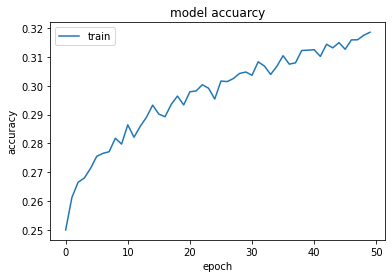

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuarcy')
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/rec_data/archive (2)/Lokesh_RESNET_model_face.h5')